In [1]:
%%html
<style>
.h1_cell, .just_text {
    box-sizing: border-box;
    padding-top:5px;
    padding-bottom:5px;
    font-family: "Times New Roman", Georgia, Serif;
    font-size: 125%;
    line-height: 22px; /* 5px +12px + 5px */
    text-indent: 25px;
    background-color: #fbfbea;
    padding: 10px;
    border-style: groove;
}

hr { 
    display: block;
    margin-top: 0.5em;
    margin-bottom: 0.5em;
    margin-left: auto;
    margin-right: auto;
    border-style: inset;
    border-width: 2px;
}
</style>

<h1>
<center>
Categorizing summaries into the Original Text using NLP
</center>

<h2>
Summary
</h2>
<div class=h1_cell>
    <p>There are 3 different articles with different topics. Students will have speech about the article. They have to summarize article. Our goal is matching students' speech to one of article.</p>
    <p>First, we will make bag of noun phrase for the 3 articles together. For each noun phrase, they will have count of appearances on each article. Then, we will give prediction on each noun phrase using Naive Bayes and we will make vector about this predictions.</p>
    <p>Then, in order to compare each summary with the vector, we will manipulate summaries. First, we will remove all stop words and Interjections from each summaries. Then, we will collect nouns and match them with words in vectors. In matching process, instead of full string matching, we will use substring matching because the summaries information are not written text but speaking text. In other words, we accept the fact that summarizing in speaking is not well organized as much as written summarizing.</p>
    <p>We will make a decision of categorizing using cosine similarity. The more higher similarity, the closer to the article.</p>
    <p>At the end, we can know what article each summary is trying to describe.</p>
    
</div>

In [2]:
import re
import nltk
import string

from nltk import sent_tokenize
from nltk.tree import Tree
punctuation = string.punctuation

from nltk.tokenize import WordPunctTokenizer
word_punct_tokenizer = WordPunctTokenizer()          #instantiate class

from nltk.tokenize import TreebankWordTokenizer
treeb_tokenizer = TreebankWordTokenizer()

nltk.download('punkt')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package punkt to /Users/edward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/edward/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

<h1>
1. Predictions about Noun Phrses from Article
</h1>

<h2>
1.1 Article to list of sentences.
</h2>

<div class=h1_cell>
    <p>article_to_list function will make the text file to list of sentences </p>
</div>

In [3]:
def article_to_list(filename):
    result = []
    with open(filename) as f:
        content = f.read()
        content = unicode(content, 'utf8').splitlines()
    for text in content:
        k = sent_tokenize(text)
        for sent in k:
            #unicode(sent).encode('UTF8')
            result.append(sent)
    return result

In [4]:
article1 = article_to_list("input1.txt")
article2 = article_to_list("input2.txt")
article3 = article_to_list("input3.txt")

<h2>
1.2 Make pandas table of sentenes.
</h2>

In [5]:
import pandas as pd
article_table = pd.DataFrame(columns=['id', 'sentence', 'label'])

In [6]:
table_id=0
for sentence in article1:
    if len(sentence) >=3:
        article_table.loc[table_id] = [table_id, sentence, 1]
        table_id+=1
for sentence in article2:
    if len(sentence) >=3:
        article_table.loc[table_id] = [table_id, sentence, 2]
        table_id+=1
for sentence in article3:
    if len(sentence) >=3:
        article_table.loc[table_id] = [table_id, sentence, 3]
        table_id+=1

In [7]:
article_table.head()

,id,sentence,label
0,0,Perspectives on Agriculture,1
1,1,Learning objectives,1
2,2,Understand the ideas of Lewis Henry Morgan and...,1
3,3,Explain the challenge to these ideas posed in ...,1
4,4,Describe alternate theories / explanations to ...,1


<h2>
1.3 Make a bag of noun phrase. 
    
    Part A, Extract NP
</h2>

<h2>
Noun Phrase Extraction
</h2>
<div class=h1_cell>
    <p>We will use Regular expression pattern matching with mltk chunker</p>
    <p>In this project, we will define NP as the below.</p>
    <p>The basic NP form is (Adjective | Noun)* (Noun Preposition)? (Adjective | Noun)* Noun</p>
</div>

In [8]:
rel_chunker = nltk.RegexpParser(r'''
    NP:
    {<JJ|JJR|JJS>*<NN|NNS|NNP|NNPS>*<NN|NNS|NNP|NNPS><IN|TO><DT>?<JJ|JJR|JJS>*<NN|NNS|NNP|NNPS|PRP>*<NN|NNS|NNP|NNPS|PRP>} 
    {<JJ|JJR|JJS>*<NN|NNS|NNP|NNPS>*<NN|NNS|NNP|NNPS>}
    {<NN|NNS|NNP|NNPS>*}
   ''')

<h3>
NP examples
</h3>

In [9]:
sent = article_table.loc[21, 'sentence']
print("Original Sentence")
print(sent)

Original Sentence
The concepts developed by Morgan and Childe remain essential to the study of prehistory.


In [10]:
chunks = rel_chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
print("how Regex chunked it")
print(chunks)

how Regex chunked it
(S
  The/DT
  (NP concepts/NNS)
  developed/VBN
  by/IN
  (NP Morgan/NNP)
  and/CC
  (NP Childe/NNP)
  remain/VBP
  essential/JJ
  to/TO
  the/DT
  (NP study/NN of/IN prehistory/NN)
  ./.)


In [11]:
def chunk_to_string(chunks):
    np_list = []
    for t in chunks:
        if type(t) != Tree: continue
        if t.label() == 'NP':
            li = []
            for word, tag in t:
                li.append(word)
        np_list.append(' '.join(li))
    return np_list

In [12]:
print("list of NP from the example sentence")
chunk_to_string(chunks)

list of NP from the example sentence


[u'concepts', u'Morgan', u'Childe', u'study of prehistory']

<h2>
1.3 Make a bag of noun phrase. 
    
    Part B, Make bag of noun phrase
</h2>

<h2>
Bag of Noun Phrase
</h2>
<div class=h1_cell>
    <p>We will use python dictionary for the bag of np.</p>
    <p>Key value will be the NP and the values are list of 3 int.</p>
    <p>3 int list stands for how many the np apears on article1, article2 and article3.</p>
</div>

In [13]:
def count_np(table, chunker):
    all_np = {}
    size = len(table)
    for i in range(size):
        sentence = table.loc[i, 'sentence']
        chunks = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sentence)))
        templist = chunk_to_string(chunks)
        label = table.iloc[i]['label']
        for np in templist:
            if np in all_np.keys():
                all_np[np][label-1] +=1
            else:
                all_np[np] = [0,0,0]
                all_np[np][label-1] +=1
    return all_np        

In [14]:
all_np = count_np(article_table,rel_chunker)

In [15]:
first5 ={k: all_np[k] for k in all_np.keys()[:5]}
first5

{u'Reason as Essential': [0, 1, 0],
 u'concept': [1, 0, 0],
 u'covert agenda': [0, 1, 0],
 u'ethical lapse in business': [0, 1, 0],
 u'ordinary people': [0, 1, 0]}

<h2>
1.4 Naive Bayes
</h2>
<div class=h1_cell>
    <p>We will use Naive Bayes and make prediction about the np.</p>
    <p>The predictions will be used for vector in matching with summaries.</p>
</div>

In [16]:
##Basic probabilities and class counts
article1_count, article2_count, article3_count = article_table.groupby('label').size()
total_count = [article1_count, article2_count, article3_count]
total_count

[123, 112, 109]

In [17]:
from __future__ import division

In [18]:
def naive_bayes_np(sentence, bag, counts, chunker):
    ans_list = []
    chunks = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sentence)))
    np_list = chunk_to_string(chunks)
    ##odd patter and wrangling
    for i in range(len(counts)):
        case_i = counts[i] / sum (count for count in counts)
        num = 1.0
        for word in np_list:
            if word not in bag:
                num *= 1
            else:
                num *= bag[word][i] / counts[i]
        ans_list.append(num * case_i)
    return tuple(ans_list)

<h2>
Accuracy Check
</h2>

In [19]:
import time

In [20]:
start = time.time()

copytable = article_table
predictions = []
val = 0
for i,row in copytable.iterrows():
    if i%50 ==0:
        print('did 50')
    pair = naive_bayes_np(row['sentence'], all_np, total_count, rel_chunker)
    predictions.append(pair.index(max(pair))+1)
    
end = time.time()
print(end-start)

did 50
did 50
did 50
did 50
did 50
did 50
did 50
0.963954925537


In [21]:
actuals = article_table['label']
zipped = zip(predictions, actuals)

In [22]:
confusion_dictionary = {(3, 3):0, (3, 2):0, (3, 1):0, (2, 3):0, (2, 2):0, (2, 1):0, (1, 3):0, (1, 2):0, (1, 1):0}
for el in zipped:
    confusion_dictionary[el] +=1

In [23]:
correct = (confusion_dictionary[(1,1)] + confusion_dictionary[(2,2)] + confusion_dictionary[(3,3)])

In [24]:
1.0*correct/len(zipped)

0.9912790697674418

<div class=h1_cell>
    <p>Wow. We got 99% accuracy in NB. It is unreal number in the real world. The reason for the consequence is the small input, first. We only have 3 different articles and the articles have 110-130 sentences. The input scale is not enough to be equally distributted. Also, the other reason is the uniqueness of the Nout Phrase. Rather than extracting Nouns, we choose to get NP. So, unique NPs makes each NP be unique.</p>
</div>

<h1>
2. Match with Summaries
</h1>

<h2>
2.1 Summary to list of sentences
</h2>

In [25]:
def summaries_to_list(filename):
    result = []
    with open(filename) as f:
        content = f.read()
        content = unicode(content, 'utf8').splitlines()
    for i in range(len(content)):
        obj = content[i].lower()
        sent_li = []
        if len(obj) ==0: continue
        else:
            k = sent_tokenize(obj)
            for sent in k:
                sent_li.append(sent)
            result.append(sent_li)
    return result

In [26]:
list_of_summaries = summaries_to_list("all_summaries.txt")

<h2>
2.2 Remove speech words using swords and text wrangling idea 
</h2>
<div class=h1_cell>
    <p>Since the summaries are speech, we need to remove stop words and Interjections to make it more like the written summaries and more syntactical.</p>
</div>

In [27]:
from nltk.corpus import stopwords
swords = stopwords.words('english')

<div class=h1_cell>
    <p>remove IN, Preposition or subordinating conjunction, from swords.</p>
</div>

In [28]:
inlist = [] ## inlist: IN elements that need to be removed in stop words
for word in sorted(swords):
    chunks = rel_chunker.parse(nltk.pos_tag(nltk.word_tokenize(word)))
    for t in chunks:
        if type(t) != Tree:
            if t[1] =="IN" or t[1] =="CC":
                inlist.append(t[0])
for word in inlist:
    swords.remove(word)

<div class=h1_cell>
    <p>add Interjections and meaningless words to stop words.</p>
    <p>This process is not fancy in Machine Learning point. But, just do it fist.</p>
</div>

In [29]:
##meaningless words
myswords = ["so", "ok", "um", "uh", "mmm", "mm", "ah", "yeah", "hmm", "hm", "ph",
            "oh", "things", "thing", "something", "category","people", 
            "example", "examples", "article", "place", "other","others", 
            "someone", "this", "that", "chapter", "just", "it", "topic",
            "topics", "chapter", "chapters", "category", "anything",
           "nope", "kind", "type", "types", "term", "terms", "means",
           "type", "types", "kind", "maybe", "theory", "way", "author",
           "task", "want", "textbook", "aspect", "aspects", "part", "lot",
           "say", "get", "got", "talk", "talks", "think", "thinks", "mention",
           "find", "finds", "remember", "anyone", "end", "ends", "intent", "c"]
for word in myswords:
    swords.append(word)

In [30]:
import string
punctuation = string.punctuation

In [31]:
def containsAnyPunc(st, punctuation):
    ##help function to filter string containing punctuation
    return 1 in [c in st for c in punctuation]

In [32]:
def sentence_wrangler(sentence, swords, punctuation):
    ans = [[],[]]
    word_tokes = word_punct_tokenizer.tokenize(sentence.lower())
    for unit in word_tokes:
        ##print(unit)
        if containsAnyPunc(unit, punctuation) or unit in swords:
            ans[1].append(unit)
        else:
            ans[0].append(unit)
    return ans

<div class=h1_cell>
    <p>example of the fisrt summary how we get meaningful and syntactical sentences.</p>
</div>

In [33]:
for sent in list_of_summaries[0]:
    print(sent)
    print(' '.join(sentence_wrangler(sent, swords, punctuation)[0]) +'.')
    print("-----------------")

ok, so, this chapter focused on um science and pure science and applied science.
focused on science and pure science and applied science.
-----------------
um, pure science is just finding out things for the greater knowledge and applied science is for a specific task in trying to figure something out.
pure science finding out for greater knowledge and applied science for specific in trying figure out.
-----------------
um, the chapter also discussed um, the defintion of life.
also discussed defintion of life.
-----------------
and the different aspects which fall into that category.
and different fall into.
-----------------
so, things like, um, homeostasis and other characteristics that help define life in it's different categories.
like homeostasis and characteristics help define life in different categories.
-----------------
um, article talked about dna and what else was the chapter about?
talked about dna and else about.
-----------------
mmm, yeah.
.
-----------------


In [34]:
sum_li = []
for summary in list_of_summaries:
    li = []
    for sent in summary:
        li.append(' '.join(sentence_wrangler(sent, swords, punctuation)[0]) +'.')
        
    sum_li.append(li)

<h2>
2.3 Make vector for the articles and summaries
</h2>
<div class=h1_cell>
    <p>First, we will sort the bag of NP from the articles.</p>
    <p>Then, this sorted bag of np will be the used as empty vector with all 0 values.</p>
    <p>count_up function will make the </p>
</div>

<h2>
Sort bag of NP and make the empty vector
</h2>

In [38]:
sorted_items = sorted(all_np.items())

In [39]:
standard_vector = []
for key, li in sorted_items:
    standard_vector.append([key, 0])

<div class=h1_cell>
    <p>Since the summaries are speech text, we will extract Noun instead of NP.</p>
    <p>In grading, we will consider that speech is not as perfect as the written text.</p>
    <p>So, in matching the aritlces and summary, we will match if a noun from sumamry is a substring of NP in articles.</p>
    <p>sum_vector function will create a vector with the same key with the articles vector, but about summary's nouns.</p>
</div>

In [40]:
match_chunker = nltk.RegexpParser(r'''
    NOUN:
    {<NN|NNS|NNP|NNPS>}
   ''')

In [41]:
def noun_to_string(chunks):
    np_list = []
    for t in chunks:
        if type(t) != Tree: continue
        if t.label() == 'NOUN':
            li = []
            for word, tag in t:
                li.append(word)
        np_list.append(' '.join(li))
    return np_list

In [42]:
def noun_in_li(li, noun):
    result = []
    b = False
    for i in range(len(li)):
        if noun in li[i]:
            b = True
            result .append(i)
    return [b, result]

In [43]:
def sum_vector(summary, basic_vec, chunker):
    not_used = []
    for sent in summary:
        chunks = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
        ##print(chunks)
        templist = noun_to_string(chunks)
        for np in templist:
            #print(np)
            status, idxli = noun_in_li(basic_vec, np)
            if status:
                for idx in idxli:
                    basic_vec[idx][1] +=1
                    #print("************************")
                    #print(basic_vec[idx])
            else:
                not_used.append((np, 1))
    #print("-----------------------------")
    return list(count for word, count in basic_vec)

<h2>
2.4 Matching Summary and categorize it.
</h2>
<div class=h1_cell>
    <p>Comparing Summary vector and aritlce vectors using cosine_similarity, we will make a predictions. The higher percentages, the closer similarity</p>
</div>

In [44]:
import math

In [45]:
def cosine_similarity(v1,v2):
    num, deno1, deno2 = 0, 0, 0
    if len(v1) != len(v2):
        print("vector size not matched")
    else:
        for i in range(len(v1)):
            num += v1[i]*v2[i]
            deno1 += v1[i]*v1[i]
            deno2 += v2[i]*v2[i]
        deno = math.sqrt(deno1*deno2)
    return num/deno if deno !=0 else 0

In [46]:
article1_vec = [pair[1][0] for pair in sorted_items]
article2_vec = [pair[1][1] for pair in sorted_items]
article3_vec = [pair[1][2] for pair in sorted_items]

In [47]:
def get_match_index(std, vec1, vec2, vec3):
    v1 = cosine_similarity(std, vec1)
    v2 = cosine_similarity(std, vec2)
    v3 = cosine_similarity(std, vec3)
    value = max(v1, v2 ,v3)
    #print(v1,v2,v3)
    if value == v1:
        return 0
    elif value == v2:
        return 1
    else:
        return 2

In [48]:
import copy

In [49]:
categorize_li = []
for summary in sum_li:
    vec = copy.deepcopy(standard_vector)
    v = sum_vector(summary, vec, match_chunker)
    idx = get_match_index(v, article1_vec, article2_vec, article3_vec)
    categorize_li.append(idx+1)

<h2>
Look Details about the result
</h2>

In [50]:
import matplotlib.pyplot as plt
import collections 

article1's count: 36
article2's count: 37
article3's count: 41


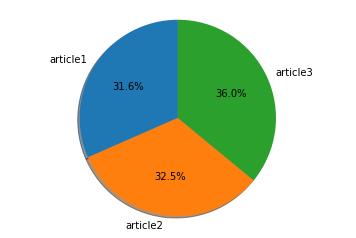

In [51]:
labels = "article1", "article2", "article3"
counter = collections.Counter(categorize_li)
values = counter.values()
for i in range(3):
    print("{}'s count: {}".format(labels[i], values[i]))
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<h2>
Wrap Up
</h2>
<div class=h1_cell>
    <p>We can see how many summaries are allocated for each articles From pie chart.</p>
    <p>It seems like evenly populated.</p>
</div>

<h2>
Things to supplement
</h2>
<div class=h1_cell>
    <p>I used (Adjective | Noun)* (Noun Preposition)? (Adjective | Noun)* Noun as the NP. However, It was not able to match all NP correctly. For example, words like 'development of human and agriculture' it cuts into 'development of human' and 'agricultue'. So, we need advanced regular expression for NP with bridging words.</p>
    <p>Also, the regular expression was not able to extract NP like 'increasing population' where VBG acts as Adjective. Moreover, NLTK has limit on classifying words with various tense. This problem has to be solved with analyze the whole sentence and need higher level </p>
    <p>In removing stop words and speech words, I manually appended words. But, to make realizable program, we need to figure out automatic ways to recognize it.</p>
    <p>We didn't used Neural Network and Pytorch. If we can apply that technology into this project, it will bring more accurate result.</p>
</div>